# House Prices: Advanced Regression Techniques
Competition Description


Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting
Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset.

_Source: [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)_

In [14]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [15]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [16]:
train_data.shape

(1460, 81)

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [23]:
train_data.isna().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
                 ... 
CentralAir          0
SaleCondition       0
Heating             0
TotalBsmtSF         0
Id                  0
Length: 81, dtype: int64

In [138]:
pd.isnull(train_data).any(1)

0       True
1       True
2       True
3       True
4       True
        ... 
1455    True
1456    True
1457    True
1458    True
1459    True
Length: 1460, dtype: bool

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459],
           dtype='int64', length=1460)

In [83]:
na_index.head()

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [106]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [25]:
train_data.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [30]:
print(f'Skewness: {train_data.SalePrice.skew()}')
print(f'Kurtosis: {train_data.SalePrice.kurt()}')

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


<AxesSubplot:>

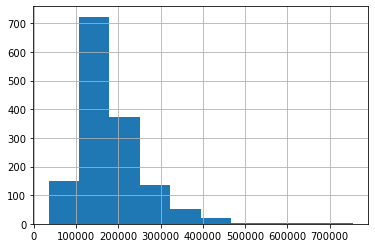

In [53]:
train_data.SalePrice.hist()

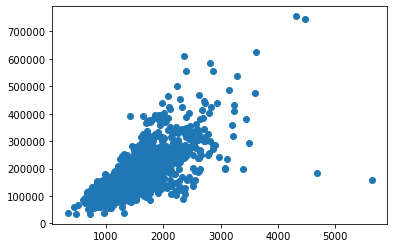

In [52]:
plt.scatter(train_data.GrLivArea, train_data.SalePrice)

In [ ]:
cont_labels = ['LotFrontage', 'LotArea', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'SalePrice']

In [164]:
def cont_scatter(df, compare, sale_price=train_data.SalePrice):
    
    plt.figure(figsize=(16,4))
    
    plt.subplot(1,3,1)
    plt.hist(df[compare])
    
    plt.subplot(1,3,2)
    plt.scatter(df[compare], sale_price)
    
    plt.subplot(1,3,3)
    plt.boxplot(df[compare])
    print(f'Median: {df[compare].median()},\nMode: {df[compare].mode()}, \
    \nSkew: {df[compare].skew()}, \nKurtosis: {df[compare].kurtosis()}, \n{df[compare].describe()}')

Median: 9478.5,
Mode: 0    7200
dtype: int64,     
Skew: 12.207687851233496, 
Kurtosis: 203.24327101886033, 
count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64


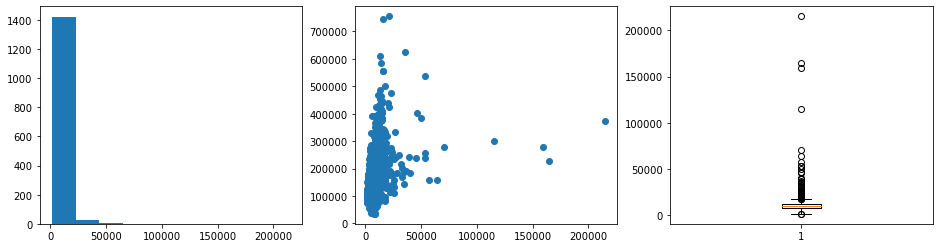

In [165]:
cont_scatter(train_data,'LotArea')